# 1. Setting up environment
Need datasets for hugging face

In [1]:
!pip install datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

from PIL import Image

import os
import copy
from copy import deepcopy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 2.1 Download Dataset

https://huggingface.co/datasets/microsoft/cats_vs_dogs

## 2.2 Cats dataset

In [4]:
from datasets import load_dataset
ds = load_dataset("microsoft/cats_vs_dogs")

In [5]:
# Filter for only cats
cats_ds = ds.filter(lambda example: example['labels'] == 0)

Filter:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [6]:
# Split the dataset
train_test_split = cats_ds['train'].train_test_split(test_size=0.2, seed=42)
test_val_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_dataset = train_test_split['train']['image']
val_dataset = test_val_split['train']['image']
test_dataset = test_val_split['test']['image']

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 9392
Validation dataset size: 1174
Test dataset size: 1175


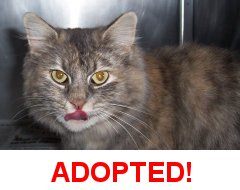

In [7]:
train_dataset[0]

In [12]:
hole_size = 20

def create_masks(N, im_h, im_w):
    x = int((im_w - hole_size) / 2.0)
    y = int((im_h - hole_size) / 2.0)
    mask = torch.zeros((1, im_h, im_w))
    mask[0, y : y + hole_size, x : x + hole_size] = 1
    masks = mask.repeat_interleave(N, dim=0)
    # masks = torch.cat(masks, dim=0)
    return masks.unsqueeze(1)

In [14]:
class CatDataset(Dataset):
    def __init__(self, all_imgs, transforms=None) -> None:
        super().__init__()
        self.transforms = transforms
        self.all_imgs = all_imgs


    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, index):
        image = self.all_imgs[index]

        transformed_img = self.transforms(image) if self.transforms else image
        # transformed_img = transformed_img[0]

        # create deep copy of image for transformation
        ground_truth_image = deepcopy(transformed_img)

        # # change center depending on where to randomize
        mask = create_masks(1, 64, 64)[0]
        transformed_img = (1 - mask) * transformed_img
        # transformed_img[:, 10:20, 10:20] = torch.rand((3, 10, 10))
        #transformed_img[:, 96:160, 96:160] = torch.rand((3, 64, 64))

        return transformed_img, ground_truth_image

In [15]:
transforms = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Resize(size=(64, 64))
])

transformed_train_dataset = CatDataset(train_dataset, transforms=transforms)
transformed_val_dataset = CatDataset(val_dataset, transforms=transforms)
transformed_test_dataset = CatDataset(test_dataset, transforms=transforms)

## 2.4 Explore Dataset

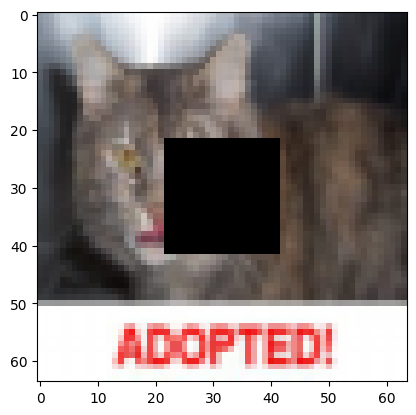

In [16]:
plt.imshow(np.transpose(transformed_train_dataset[0][0], (1, 2, 0)))

In [9]:
item0, item1, item2 = transformed_train_dataset[10], transformed_train_dataset[1], transformed_train_dataset[2]

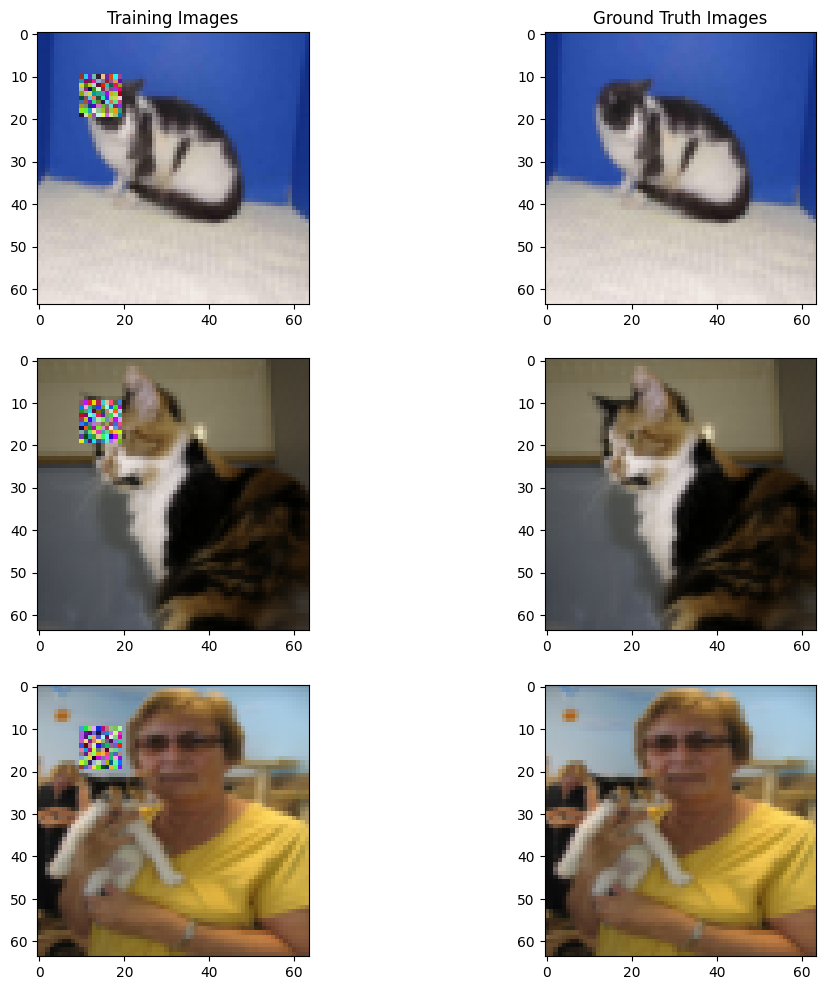

In [17]:
# train image
f, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].imshow(np.transpose(item0[0], (1, 2, 0)))
ax[0, 1].imshow(np.transpose(item0[1], (1, 2, 0)))
ax[1, 0].imshow(np.transpose(item1[0], (1, 2, 0)))
ax[1, 1].imshow(np.transpose(item1[1], (1, 2, 0)))
ax[2, 0].imshow(np.transpose(item2[0], (1, 2, 0)))
ax[2, 1].imshow(np.transpose(item2[1], (1, 2, 0)))

ax[0, 0].set_title("Training Images");
ax[0, 1].set_title("Ground Truth Images");


## 2.5 Setup Dataloader

In [11]:
BATCH_SIZE = 8
train_loader = DataLoader(transformed_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(transformed_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=BATCH_SIZE, shuffle=True)